## Residential energy emissions demo

This notebook gives a demonstration of how energy and emissions per capita can be calculated for the metro area of Lille.

It is a first effort and contains many necessary (at this point) assumptions, most of which can hopefully be replaced with better data or better assumptions in the future.

The following data are used:
 - [BNDB](https://www.bdnb.eu/bdnb/bdnb_presentation/) database containing energy and emission certificates from [DPE](https://www.ecologie.gouv.fr/diagnostic-performance-energetique-dpe) as well as building locations
 - [EUBUCCO](https://eubucco.com/) data of building footprints, heights, type, age
 - INSEE population and density data, calculated previously using custom spatial units designed for the urban mobility survey in Lille metro

For this demo we use BNDB and INSEE data ffor rom the French department 'Nord' (# 59), which is merged with EUBUCCO data for the metro of Lille 

The most important assumptions made for now are:
 - Estimation of number of stories based on building height with EUBUCCO data, to enable calculation of Gross Floor Area. See section 4 
 - Assume that all buildings with no type label in EUBUCCO are not residential buildings
 - Assume a constant 1.2 scaling factor between living area and gross floor area in all buildings
 - Assume that the share of building vintages for buildings with age attributes in EUBUCCO is representative of the actual vintage distribution in spatial units

Further, one possible bias inherited from the type labelling in EUBUCCO is the labelling of mixed-use multi-storey buildings as solely residential. I suspect this becuase the center of Lille, where there is a high concentration of large multi-storey buildings, has by far the highest calculated residential m2/cap (83 m2/cap, wrt average of ~50 m2/cap). I suspect that some large mixed-use buildings (which are probably majority residential) are classified as residential only, leading to an overestimation of residential floorspace and m2/cap. This is to be investigated further.

In [1]:
# load required libraries

import pandas as pd
import geopandas as gpd
import numpy as np
from pyproj import CRS
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import pickle
from shapely.validation import make_valid
from citymob import remove_holes, remove_invalid_geoms, remove_slivers, import_csv_w_wkt_to_gdf
import sys
from shapely.geometry import Point, Polygon
import math

### 1. Load and clean DPE and georeference data from BNDB database

#### Assumptions/decisions in this section: 
 - restrict to DPE estimates using the 2021 methodology only

The [dpe_logement](https://www.bdnb.eu/schema/latest/tables/dpe_logement.html) file contains housing DPE data including energy and emission intensities for residential dwellings, and physical building characteristics 

In [2]:
dpe_log=pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/dpe_logement.csv')
dpe_log_col=dpe_log.columns.to_list() # there are a lot of columns
dpe_log.head()

C:\Users\peter\AppData\Local\Temp\ipykernel_11736\2919012715.py:1: DtypeWarning: Columns (8,17,18,19,20,26,29,35,39,42,48,70,75,76,77,84,85,86,92,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  dpe_log=pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/dpe_logement.csv')


,identifiant_dpe,code_departement_insee,arrete_2021,type_dpe,type_batiment_dpe,periode_construction_dpe,annee_construction_dpe,version,date_etablissement_dpe,date_reception_dpe,...,type_porte,surface_porte,u_porte,classe_inertie,deperdition_mur,deperdition_baie_vitree,deperdition_plancher_bas,deperdition_plancher_haut,deperdition_pont_thermique,deperdition_porte
0,0059L1000001@,59,0,dpe arrêté 2012 3cl immeuble,immeuble,1989-2000,1996.0,NaN,NaN,2017/05/30 00:00:00,...,NaN,NaN,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN
1,0059L1000002A,59,0,dpe arrêté 2012 3cl immeuble,immeuble,1948-1974,1971.0,NaN,NaN,2017/05/31 00:00:00,...,NaN,NaN,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN
2,0059L1000003,59,0,dpe arrêté 2012 3cl logement,appartement,1989-2000,1995.0,NaN,NaN,2019/07/25 00:00:00,...,NaN,NaN,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN
3,0059L1000004,59,0,dpe arrêté 2012 3cl logement,appartement,1989-2000,1995.0,NaN,NaN,2019/07/25 00:00:00,...,NaN,NaN,NaN,Moyenne,NaN,NaN,NaN,NaN,NaN,NaN
4,0059L1000005D,59,0,dpe arrêté 2012 3cl logement,appartement,1989-2000,1995.0,NaN,NaN,2019/08/04 00:00:00,...,NaN,NaN,NaN,Lourde,NaN,NaN,NaN,NaN,NaN,NaN


Restrict to dwellings with DPE records using the updated 2021 methodology. These records also contain emission intensities, and dwelling living area values

In [3]:
print('total number of records', len(dpe_log))
dpe_log=dpe_log.loc[dpe_log['arrete_2021']==1,]
print('total number of records with 2021 method DPE', len(dpe_log))

total number of records 284876
total number of records with 2021 method DPE 51811


Use the `adresse` and `rel_batiment_groupe_dpe_logement` files to add geographic data to the DPE data, including point estimates of the building addresses. NB the points are not individual specific to individual buildings or dwellings, as individual addresses can relate to multiple building groups, and each building group can refer to multiple buildings/dwellings. This is a part of the [hierarchical](https://www.bdnb.eu/documentation/modele_donnees/) building location identification in BNDB, and the lack of specific location id for individual dwellings in the public BNDB, which we don't dwell on here.

In [4]:
# we know the crs of the csv file is 2154, as it is the same as the gpkg which can also be donwloaded from BNDB and contains mostly the same info as `adresse`
add = import_csv_w_wkt_to_gdf('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/adresse.csv',crs=2154,geometry_col='WKT',gc='code_postal') # gc means that the specified column is read as a string
add.head()

,WKT,cle_interop_adr,code_departement_insee,numero,rep,nom_voie,type_voie,code_commune_insee,code_postal,libelle_commune,source,geometry
0,POINT (761237.127001409 6993772.84289119),02-AISN-276828,59,7,NaN,des bruniers,rue,59241,NaN,Floyon,Arcep,POINT (761237.127 6993772.843)
1,POINT (737080.587487689 7028881.04234662),186855650575723,59,6,B,des dentellieres,avenue,59606,NaN,Valenciennes,Arcep,POINT (737080.587 7028881.042)
2,POINT (736851.339650684 7029549.26831763),186855700165357,59,43,B,du senateur girard,avenue,59606,NaN,Valenciennes,Arcep,POINT (736851.340 7029549.268)
3,POINT (736950.725348686 7029579.81433162),186855740577684,59,19,NaN,du marechal foch,avenue,59606,NaN,Valenciennes,Arcep,POINT (736950.725 7029579.814)
4,POINT (737085.741848688 7029422.28830762),186856150579663,59,3,NaN,girot,cour,59606,NaN,Valenciennes,Arcep,POINT (737085.742 7029422.288)


In [5]:
# then load the file with ids containing the relationship between addresses ('cle_interop_adr'), building groups ('batiment_groupe_id'), and dpe ('identifiant_dpe')
rel_bldgroup_dpe_log=pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/rel_batiment_groupe_dpe_logement.csv')
rel_bldgroup_dpe_log.head()

,batiment_groupe_id,identifiant_dpe,code_departement_insee,cle_interop_adr,adresse_brut,adresse_geocodee,fiabilite_geocodage
0,59512000IN0090_b45ee30e81da3f7,1959V2014824D,59,59512_2540_00095,95 Rue D Hem 59100 Roubaix,95 Rue d’Hem 59100 Roubaix,très fiable
1,59512000IO0196_67d7fd8ce86b410,1459V2008109X,59,59512_2720_00009,9 Rue Ingres 59100 Roubaix,9 Rue Ingres 59100 Roubaix,très fiable
2,59512000IK0019_5206a20845e2bc4,1659L1003092T,59,59512_1300_00036,36 Rue Coligny 59100 Roubaix,36 Rue Coligny 59100 Roubaix,très fiable
3,59512000IK0172_1be81f80ce0da53,1559V2010882@,59,59512_1300_00009,9 Rue Coligny 59100 Roubaix,9 Rue Coligny 59100 Roubaix,très fiable
4,59512000IK0153_cfaf8654038c76e,1659V1003062R,59,59512_4250_00022,22 Rue Pascal 59100 Roubaix,22 Rue Pascal 59100 Roubaix,très fiable


In [7]:
geo=add.loc[:,['cle_interop_adr','code_commune_insee','libelle_commune','geometry','numero','nom_voie','code_postal']].merge(rel_bldgroup_dpe_log.loc[:,['cle_interop_adr','batiment_groupe_id','identifiant_dpe','adresse_geocodee']])
geo.head()

,cle_interop_adr,code_commune_insee,libelle_commune,geometry,numero,nom_voie,code_postal,batiment_groupe_id,identifiant_dpe,adresse_geocodee
0,59001_0060_00015,59001,Abancourt,POINT (715336.028 7014730.213),15,du couvent,59268,59001000ZL0114_2e9776063773512,2159E0128380Z,15 Rue Du Couvent 59268 Abancourt
1,59001_0100_00002,59001,Abancourt,POINT (715468.712 7015138.178),2,des fresnois,59268,590010000U1261_f0446f7084996ac,1659V2003702T,2 Rue des Fresnois 59268 Abancourt
2,59001_0100_00010,59001,Abancourt,POINT (715531.767 7015171.651),10,des fresnois,59268,uf590010396118_11a5ab3d1aaf7e1,1959V2007645G,10 Rue des Fresnois 59268 Abancourt
3,59001_0100_00020,59001,Abancourt,POINT (715392.284 7015293.327),20,des fresnois,59268,590010000U1578_762209dcad042a4,1459V2006717A,20 Rue des Fresnois 59268 Abancourt
4,59001_0100_00024,59001,Abancourt,POINT (715350.175 7015332.970),24,des fresnois,59268,uf590010000068_2cab49d0f61e5be,2159E0290655I,24 Rue Des Fresnois 59268 Abancourt


In [8]:
# define which dpe columns we want to keep and merge with the geo data
cols=['identifiant_dpe','arrete_2021','type_batiment_dpe','periode_construction_dpe','annee_construction_dpe','nombre_niveau_logement','nombre_niveau_immeuble', 'surface_habitable_immeuble',
                       'surface_habitable_logement', 'conso_5_usages_ep_m2','conso_5_usages_ef_m2', 'emission_ges_5_usages_m2',
                       'type_installation_chauffage','type_energie_chauffage','type_generateur_chauffage','type_generateur_chauffage_anciennete','type_installation_ecs','type_energie_ecs','type_generateur_ecs','type_generateur_ecs_anciennete',
                       'type_production_energie_renouvelable','type_vitrage','type_materiaux_menuiserie','type_isolation_mur_exterieur','type_isolation_plancher_bas','type_plancher_bas_deperditif','type_isolation_plancher_haut','type_plancher_haut_deperditif']
dpe_gdf=geo.merge(dpe_log.loc[:,cols])
# this gdf is slightly larger than the dpe_log gdf because there are some 'identifiant_dpe' which refer to multiple addresses
dpe_gdf.head()

,cle_interop_adr,code_commune_insee,libelle_commune,geometry,numero,nom_voie,code_postal,batiment_groupe_id,identifiant_dpe,adresse_geocodee,...,type_generateur_ecs,type_generateur_ecs_anciennete,type_production_energie_renouvelable,type_vitrage,type_materiaux_menuiserie,type_isolation_mur_exterieur,type_isolation_plancher_bas,type_plancher_bas_deperditif,type_isolation_plancher_haut,type_plancher_haut_deperditif
0,59001_0060_00015,59001,Abancourt,POINT (715336.028 7014730.213),15,du couvent,59268,59001000ZL0114_2e9776063773512,2159E0128380Z,15 Rue Du Couvent 59268 Abancourt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,59001_0100_00024,59001,Abancourt,POINT (715350.175 7015332.970),24,des fresnois,59268,uf590010000068_2cab49d0f61e5be,2159E0290655I,24 Rue Des Fresnois 59268 Abancourt,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,59001_0174_00001,59001,Abancourt,POINT (714912.768 7014753.244),1,du petit bois,59268,59001000ZL0147_36b68127fe49cf7,2259E1509156U,1 Rue Du Petit Bois 59268 Abancourt,...,ecs thermodynamique electrique(pac ou ballon),neuf,NaN,double vitrage,métal avec rupture de pont thermique,ITI,ITE,dalle béton,ITI,plafond bois sous solives bois
3,59001_0240_00038,59001,Abancourt,POINT (714995.297 7015391.041),38,grand rue,59268,uf590010290913_f0c288a73424092,2259E1840909N,38 Grand Rue 59268 Abancourt,...,NaN,NaN,NaN,double vitrage,bois,ITI,ITI,dalle béton,ITI,plafond bois sous solives bois
4,59001_0260_00009,59001,Abancourt,POINT (715117.524 7015147.249),9,verte,59268,uf590010372730_ad0c213a7dfb0f7,2259E1165887D,9 Rue Verte 59268 Abancourt,...,ecs thermodynamique electrique(pac ou ballon),neuf,NaN,double vitrage,pvc,ITI,non isole,dalle béton,ITI,inconnu


In [9]:
dpe_gdf['identifiant_dpe'].value_counts().head()

2159E0304383I    87
2259E1285018C    42
2259E1268070G    42
2259E1266556A    42
2259E1268049L    42
Name: identifiant_dpe, dtype: int64

Briefly show how buildings in this sample from Nord vary in energy/emission intensity by building type and age

In [10]:
# houses are most inefficient compared to larger buildings and apartment buildings, but not a big diff
dpe_gdf.groupby('type_batiment_dpe')['conso_5_usages_ef_m2'].mean()

type_batiment_dpe
appartement    168.285729
immeuble       187.807199
maison         197.212200
Name: conso_5_usages_ef_m2, dtype: float64

In [11]:
# as expected, final energy is lower in newer buildings, and vice versa
dpe_gdf.groupby('periode_construction_dpe')['conso_5_usages_ef_m2'].mean()

periode_construction_dpe
1948-1974     227.814422
1975-1977     215.148335
1978-1982     171.564648
1983-1988     151.790886
1989-2000     129.365072
2001-2005     118.846214
2006-2012     116.147301
2013-2021      78.323022
après 2021     68.563914
avant 1948    195.727311
Name: conso_5_usages_ef_m2, dtype: float64

In [12]:
# emissions also lower in newer buildings. One exception (also applied to energy) is that the oldest age group <1948 is not the most energy/emission intensive. 
# Buildings building between 1948-1977 are the working performing in terms of energy and emissions
dpe_gdf.groupby('periode_construction_dpe')['emission_ges_5_usages_m2'].mean()

periode_construction_dpe
1948-1974     45.118825
1975-1977     42.894110
1978-1982     31.829800
1983-1988     25.324540
1989-2000     19.678905
2001-2005     18.828863
2006-2012     18.887318
2013-2021     13.033626
après 2021    13.780008
avant 1948    33.838785
Name: emission_ges_5_usages_m2, dtype: float64

### 2. Restrict to the relevant city boundary and group by spatial units (postcode/other)

Now we load in the spatial boundary for the Lille metro region, and then the shapefiles of the administrative units

<AxesSubplot:>

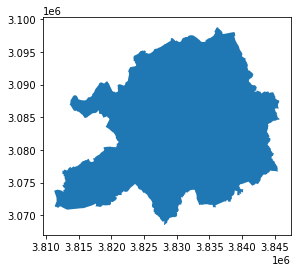

In [13]:
bound=import_csv_w_wkt_to_gdf('../../city_mobility/outputs/city_boundaries/Lille.csv',crs=3035,geometry_col='geometry')
bound.plot()

In [14]:
dpe_gdf.to_crs(3035,inplace=True)
# restrict dpe records to those within the city boundary
dpe_city=gpd.sjoin(dpe_gdf,bound.drop(columns='crs'))
dpe_city.head()

,cle_interop_adr,code_commune_insee,libelle_commune,geometry,numero,nom_voie,code_postal,batiment_groupe_id,identifiant_dpe,adresse_geocodee,...,type_generateur_ecs_anciennete,type_production_energie_renouvelable,type_vitrage,type_materiaux_menuiserie,type_isolation_mur_exterieur,type_isolation_plancher_bas,type_plancher_bas_deperditif,type_isolation_plancher_haut,type_plancher_haut_deperditif,index_right
459,59009_0011_00008,59009,Villeneuve-d'Ascq,POINT (3837013.352 3083313.020),8,de l'abbe bonpain,59650,59009000LI0415_4ce65969680ea17,2259E0681836U,8 Rue De L'Abbe Bonpain 59650 Villeneuve-d'Ascq,...,très ancien,NaN,double vitrage,pvc,ITI,non isole,NaN,inconnu,NaN,0
460,59009_0011_00018,59009,Villeneuve-d'Ascq,POINT (3837092.488 3083430.352),18,de l'abbe bonpain,59650,59009000LI0415_4ce65969680ea17,2159E0252922B,18 Rue De L'Abbe Bonpain 59650 Villeneuve-d'Ascq,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
461,59009_0021_00080,59009,Villeneuve-d'Ascq,POINT (3837799.768 3078537.581),80,de l'abbe cousin,59650,59009000PK0861_cf308d80abe9c5f,2159E0214389A,80 Rue De L'Abbe Cousin 59650 Villeneuve-d'Ascq,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
462,59009_0021_00097,59009,Villeneuve-d'Ascq,POINT (3837856.508 3078410.403),97,de l'abbe cousin,59650,59009000PK0085_d2ce62130aa18e1,2259E0557428W,97 Rue De L'Abbe Cousin 59650 Villeneuve-d'Ascq,...,récent(<15ans),NaN,double vitrage,bois,ITI,non isole,dalle béton,ITI,autre type de plafond non répertorié,0
463,59009_0021_00127,59009,Villeneuve-d'Ascq,POINT (3837919.076 3078355.125),127,de l'abbe cousin,59650,59009000PK0105_c51e20e62cf197b,2259E1104110C,127 Rue De L'Abbe Cousin 59650 Villeneuve-d'Ascq,...,NaN,NaN,double vitrage,pvc,ITI,non isole,dalle béton,ITI,combles aménagés sous rampant,0


In [15]:
# load in the shapefile of administrative units (which are defined based on the custom shapefiles in the source data of the Lille metropole urban mobility survey)
# we already have the population density calculated for these units
gu=import_csv_w_wkt_to_gdf('../../city_mobility/outputs/density_geounits/Lille_pop_density_lowres.csv',crs=3035,geometry_col='geometry')
gu.head()

,geo_unit,geometry,area,Population,Density
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0
1,102,"POLYGON ((3830948.302 3080000.986, 3830842.526...",1.736899,17020.0,9799.0
2,103,"POLYGON ((3830813.962 3079445.052, 3830830.781...",1.332421,20474.0,15366.0
3,104,"POLYGON ((3830131.702 3080002.606, 3830140.054...",1.467545,20511.0,13976.0
4,105,"POLYGON ((3829671.427 3080837.090, 3829662.212...",0.989090,15571.0,15743.0


In [62]:
dpe_gu=gpd.sjoin(gu,dpe_city.drop(columns='index_right'))
dpe_gu.drop(columns='index_right',inplace=True)
dpe_gu_df=pd.DataFrame(dpe_gu.drop(columns='geometry'))
dpe_gu.head()

,geo_unit,geometry,area,Population,Density,cle_interop_adr,code_commune_insee,libelle_commune,numero,nom_voie,...,type_generateur_ecs,type_generateur_ecs_anciennete,type_production_energie_renouvelable,type_vitrage,type_materiaux_menuiserie,type_isolation_mur_exterieur,type_isolation_plancher_bas,type_plancher_bas_deperditif,type_isolation_plancher_haut,type_plancher_haut_deperditif
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# check how many buildings we have per spatial unit. Not bad, around 400 on average, min 118 and max 1000
dpe_gu['geo_unit'].value_counts().describe()

count     57.000000
mean     427.824561
std      190.868047
min      118.000000
25%      312.000000
50%      385.000000
75%      500.000000
max      991.000000
Name: geo_unit, dtype: float64

In [18]:
# see how efficiency varies per spatial unit. 
# Not a huge spread but decent enough
dpe_gu.groupby('geo_unit')['conso_5_usages_ef_m2'].mean().describe()

count     57.000000
mean     177.660506
std       22.955701
min      134.863141
25%      165.512341
50%      173.929720
75%      185.801509
max      298.721849
Name: conso_5_usages_ef_m2, dtype: float64

In [19]:
# see how emissions varies per spatial unit. 
# a bit of a bigger std for emissions
dpe_gu.groupby('geo_unit')['emission_ges_5_usages_m2'].mean().describe()

count    57.000000
mean     31.403465
std       6.466884
min      17.355135
25%      28.443865
50%      30.896431
75%      33.770356
max      63.400369
Name: emission_ges_5_usages_m2, dtype: float64

### 3. Calculate summary efficiency and emission intensity stats by spatial unit

In [20]:
en_su=pd.DataFrame(dpe_gu.groupby('geo_unit')['conso_5_usages_ef_m2'].mean()).reset_index()

In [21]:
em_su=pd.DataFrame(dpe_gu.groupby('geo_unit')['emission_ges_5_usages_m2'].mean()).reset_index()

In [22]:
gu_stats=gu.merge(em_su)
gu_stats=gu_stats.merge(en_su)
gu_stats.head()

,geo_unit,geometry,area,Population,Density,emission_ges_5_usages_m2,conso_5_usages_ef_m2
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,28.321199,180.503386
1,102,"POLYGON ((3830948.302 3080000.986, 3830842.526...",1.736899,17020.0,9799.0,25.871121,169.616578
2,103,"POLYGON ((3830813.962 3079445.052, 3830830.781...",1.332421,20474.0,15366.0,21.321014,160.114032
3,104,"POLYGON ((3830131.702 3080002.606, 3830140.054...",1.467545,20511.0,13976.0,31.035073,187.261464
4,105,"POLYGON ((3829671.427 3080837.090, 3829662.212...",0.989090,15571.0,15743.0,21.730266,165.512341


<AxesSubplot:>

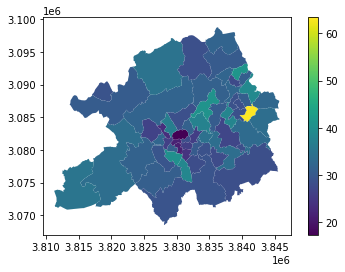

In [23]:
# see how average emission intensity varies through the city
gu_stats.plot(column='emission_ges_5_usages_m2',legend=True)

<AxesSubplot:>

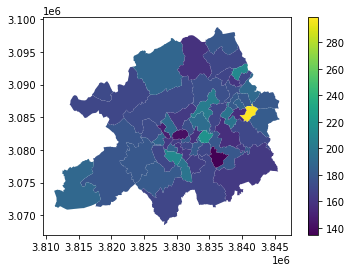

In [24]:
# see how average energy efficiency varies through the city
gu_stats.plot(column='conso_5_usages_ef_m2',legend=True)

In [25]:
# add count of DPEs to the stats by geo unit
N=pd.DataFrame(dpe_gu['geo_unit'].value_counts()).reset_index()
N.rename(columns={'index':'geo_unit','geo_unit':'N'},inplace=True)
gu_stats=gu_stats.merge(N)
gu_stats.head()

,geo_unit,geometry,area,Population,Density,emission_ges_5_usages_m2,conso_5_usages_ef_m2,N
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,28.321199,180.503386,264
1,102,"POLYGON ((3830948.302 3080000.986, 3830842.526...",1.736899,17020.0,9799.0,25.871121,169.616578,588
2,103,"POLYGON ((3830813.962 3079445.052, 3830830.781...",1.332421,20474.0,15366.0,21.321014,160.114032,991
3,104,"POLYGON ((3830131.702 3080002.606, 3830140.054...",1.467545,20511.0,13976.0,31.035073,187.261464,828
4,105,"POLYGON ((3829671.427 3080837.090, 3829662.212...",0.989090,15571.0,15743.0,21.730266,165.512341,519


In [26]:
# so the one geo_unit with very high energy and emission intensity is '149', and this one had 417 observations, so not a small sample, but maybe skewed in terms of age.
# indeed we see the dpes from this location are almost all from <1975
dpe_gu.loc[dpe_gu['geo_unit']==149,'periode_construction_dpe'].value_counts()

1948-1974     288
avant 1948    119
2006-2012       3
1989-2000       3
1978-1982       1
1983-1988       1
1975-1977       1
2013-2021       1
Name: periode_construction_dpe, dtype: int64

In [28]:
# this geo-unit is located mostly within commune of Roubaix
dpe_gu.loc[dpe_gu['geo_unit']==149,'libelle_commune'].value_counts()

Roubaix           402
Lys-lez-Lannoy     10
Hem                 4
Leers               1
Name: libelle_commune, dtype: int64

In [29]:
# mostly gas heating (collective gas might be gas by building)
dpe_gu.loc[dpe_gu['geo_unit']==149,['type_installation_chauffage','type_energie_chauffage']].value_counts()

type_installation_chauffage  type_energie_chauffage
collectif                    gaz                       218
individuel                   gaz                       120
                             electricite                28
collectif                    reseau de chaleur          10
                             electricite                 2
individuel                   bois                        1
                             charbon                     1
                             fioul                       1
dtype: int64

In [30]:
# many of the gas heaters are very old. Less than 15 years old wouldn't count as 'recent' to me
dpe_gu.loc[dpe_gu['geo_unit']==149,['type_energie_chauffage','type_generateur_chauffage_anciennete']].value_counts()

type_energie_chauffage  type_generateur_chauffage_anciennete
gaz                     très ancien                             167
                        récent(<15ans)                          101
                        neuf                                     52
                        ancien                                   18
electricite             neuf                                      3
bois                    neuf                                      1
electricite             récent(<15ans)                            1
fioul                   très ancien                               1
dtype: int64

In [31]:
# many buildings with no wall insulation
dpe_gu.loc[dpe_gu['geo_unit']==149,'type_isolation_mur_exterieur'].value_counts()

non isole    223
ITI           67
inconnu       59
ITE           17
ITI+ITR        1
ITR            1
Name: type_isolation_mur_exterieur, dtype: int64

### 4. Load in EUBUCCO data, prepare to scale the DPE data to the stock level

#### Assumptions/decisions in this section:
 - All buildings with height of 0m in EUBUCCO are assumed to be 1m tall, for the purpose of calculating stories based on height
 - Assume an average floor height of 4m for converting building height to stories, with exception of 1-storey buildings which are assumed to be up to 5m tall
 - Restrict EUBUCCO data to only residential labelled buildings. Assume that buildings with no label are not residential
 - Assume a constant 1.2 scaling factor between living area and gross floor area in all buildings



Next, we load in EUBUCCO data for the same spatial boundary, and see to what extent we can scale up our samples to be comprehensive for each spatial unit

In [33]:
bldg=gpd.read_file('../../MSCA_data/BuildingsDatabase/clips/eubucco_lille.shp')
bldg.head()

,fid,id,height,age,type,id_source,type_sourc,geometry
0,19439901.0,v0.1-FRA.7.2.5.19_1-4528,4.5,NaN,non-residential,BATIMENT0000000288165364,Commercial et services,"POLYGON ((3828709.383 3069743.102, 3828734.808..."
1,19442319.0,v0.1-FRA.7.2.5.19_1-6946,3.3,NaN,None,BATIMENT0000000288165365,Indifférencié,"POLYGON ((3828741.619 3069724.755, 3828755.805..."
2,19439903.0,v0.1-FRA.7.2.5.19_1-4530,0.0,2007.0,residential,BATIMENT0000000288165418,Résidentiel,"POLYGON ((3829149.498 3069720.967, 3829159.681..."
3,19323988.0,v0.1-FRA.7.2.5.13_1-1192,0.0,2006.0,residential,BATIMENT0000000288165415,Résidentiel,"POLYGON ((3829148.454 3069684.635, 3829164.402..."
4,19323943.0,v0.1-FRA.7.2.5.13_1-1147,4.4,1985.0,residential,BATIMENT0000000288165338,Résidentiel,"POLYGON ((3829195.216 3069659.877, 3829195.292..."


In [34]:
# check coverage of relevant attributes in EUBUCCO
print(100*round(sum(bldg['type'].value_counts())/len(bldg),2), '% of buildings have a type attribute')
print(100*round(sum(bldg['age'].value_counts())/len(bldg),3), '% of buildings have an age attribute')
print(100*round(sum(bldg['height'].value_counts())/len(bldg),3), '% of buildings have a height attribute')

70.0 % of buildings have a type attribute
61.3 % of buildings have an age attribute
99.8 % of buildings have a height attribute


In [35]:
# building ages are numeric, so will need to be converted to the age ranges
bldg['age'].value_counts().head()

1900.0    27030
1890.0     9309
1880.0     9110
1930.0     9043
1920.0     7531
Name: age, dtype: int64

In [36]:
# for the purpose of calculating stories, turn all buildings with 0 height or NA height to height of 1m
bldg.loc[bldg['height'].isna(),'height']=1
bldg.loc[bldg['height']==0,'height']=1

In [37]:
bldg['Footprint']=bldg.area
bldg['Stories']=np.ceil(bldg['height']/4)
# insert exception for buildings of height 4-5m, which are unlikely to have 2 stories
bldg.loc[bldg['height']<=5,'Stories']=1
bldg['Floor_area']=bldg['Footprint']*bldg['Stories']
bldg['Center']=bldg.centroid
bldg.head()

,fid,id,height,age,type,id_source,type_sourc,geometry,Footprint,Stories,Floor_area,Center
0,19439901.0,v0.1-FRA.7.2.5.19_1-4528,4.5,NaN,non-residential,BATIMENT0000000288165364,Commercial et services,"POLYGON ((3828709.383 3069743.102, 3828734.808...",238.121936,1.0,238.121936,POINT (3828720.173 3069732.445)
1,19442319.0,v0.1-FRA.7.2.5.19_1-6946,3.3,NaN,None,BATIMENT0000000288165365,Indifférencié,"POLYGON ((3828741.619 3069724.755, 3828755.805...",134.849239,1.0,134.849239,POINT (3828746.700 3069717.174)
2,19439903.0,v0.1-FRA.7.2.5.19_1-4530,1.0,2007.0,residential,BATIMENT0000000288165418,Résidentiel,"POLYGON ((3829149.498 3069720.967, 3829159.681...",136.628575,1.0,136.628575,POINT (3829154.337 3069714.338)
3,19323988.0,v0.1-FRA.7.2.5.13_1-1192,1.0,2006.0,residential,BATIMENT0000000288165415,Résidentiel,"POLYGON ((3829148.454 3069684.635, 3829164.402...",151.302895,1.0,151.302895,POINT (3829156.539 3069680.471)
4,19323943.0,v0.1-FRA.7.2.5.13_1-1147,4.4,1985.0,residential,BATIMENT0000000288165338,Résidentiel,"POLYGON ((3829195.216 3069659.877, 3829195.292...",185.451388,1.0,185.451388,POINT (3829197.558 3069664.696)


In [38]:
# setting centroid as bldg geometry avoids buildings being mapped to multiple geounits
bldg.rename(columns={'geometry':'bldg_footprint'},inplace=True)
bldg.set_geometry('Center',inplace=True)
bldg.geometry

0         POINT (3828720.173 3069732.445)
1         POINT (3828746.700 3069717.174)
2         POINT (3829154.337 3069714.338)
3         POINT (3829156.539 3069680.471)
4         POINT (3829197.558 3069664.696)
                       ...               
516631    POINT (3817484.423 3088009.515)
516632    POINT (3817459.475 3087980.069)
516633    POINT (3817453.720 3088001.585)
516634    POINT (3817465.714 3087979.045)
516635    POINT (3817453.997 3087986.468)
Name: Center, Length: 516636, dtype: geometry

In [40]:
## join EUBUCCO data to the spatial units
bldg_gu=gpd.sjoin(bldg,gu.loc[:,['geo_unit','geometry']])
bldg_gu.drop(columns='index_right',inplace=True)
bldg_gu.head()

,fid,id,height,age,type,id_source,type_sourc,bldg_footprint,Footprint,Stories,Floor_area,Center,geo_unit
0,19439901.0,v0.1-FRA.7.2.5.19_1-4528,4.5,NaN,non-residential,BATIMENT0000000288165364,Commercial et services,"POLYGON ((3828709.383 3069743.102, 3828734.808...",238.121936,1.0,238.121936,POINT (3828720.173 3069732.445),131
1,19442319.0,v0.1-FRA.7.2.5.19_1-6946,3.3,NaN,None,BATIMENT0000000288165365,Indifférencié,"POLYGON ((3828741.619 3069724.755, 3828755.805...",134.849239,1.0,134.849239,POINT (3828746.700 3069717.174),131
2,19439903.0,v0.1-FRA.7.2.5.19_1-4530,1.0,2007.0,residential,BATIMENT0000000288165418,Résidentiel,"POLYGON ((3829149.498 3069720.967, 3829159.681...",136.628575,1.0,136.628575,POINT (3829154.337 3069714.338),131
3,19323988.0,v0.1-FRA.7.2.5.13_1-1192,1.0,2006.0,residential,BATIMENT0000000288165415,Résidentiel,"POLYGON ((3829148.454 3069684.635, 3829164.402...",151.302895,1.0,151.302895,POINT (3829156.539 3069680.471),131
4,19323943.0,v0.1-FRA.7.2.5.13_1-1147,4.4,1985.0,residential,BATIMENT0000000288165338,Résidentiel,"POLYGON ((3829195.216 3069659.877, 3829195.292...",185.451388,1.0,185.451388,POINT (3829197.558 3069664.696),131


In [41]:
# prepare summary stats by spatial unit of EUBUCCO data, e.g. type and age shares 
bldg_type=pd.DataFrame(bldg_gu.groupby('geo_unit')['type'].count()).reset_index()
bldg_age=pd.DataFrame(bldg_gu.groupby('geo_unit')['age'].count()).reset_index()
N_bldg=pd.DataFrame(bldg_gu.groupby('geo_unit')['id'].count()).reset_index()
N_bldg.rename(columns={'id':'count'},inplace=True)

In [42]:
bldg_gu_stats=N_bldg.merge(bldg_type)
bldg_gu_stats=bldg_gu_stats.merge(bldg_age)
bldg_gu_stats['type_cov']=bldg_gu_stats['type']/bldg_gu_stats['count']
bldg_gu_stats['age_cov']=bldg_gu_stats['age']/bldg_gu_stats['count']

In [43]:
# see variation by spatial unit of type coverage: not bad, most geo_units have approx 70% coverage of type
bldg_gu_stats['type_cov'].describe()

count    57.000000
mean      0.704488
std       0.034835
min       0.609994
25%       0.687196
50%       0.707539
75%       0.727201
max       0.791601
Name: type_cov, dtype: float64

In [44]:
# see variation by spatial unit of age coverage:  not bad, most geo_units have approx 60% coverage of age
bldg_gu_stats['age_cov'].describe()

count    57.000000
mean      0.612687
std       0.035381
min       0.517132
25%       0.591851
50%       0.615576
75%       0.635668
max       0.679310
Name: age_cov, dtype: float64

In [45]:
# define a 'vintage' column to match the `periode_construction_dpe` dpe variable
bldg_gu['vintage']='unknown'
bldg_gu.loc[bldg_gu['age']<1948,'vintage']='<1948'
bldg_gu.loc[(bldg_gu['age']>1947) & (bldg_gu['age']<1975),'vintage']='1948-1974'
bldg_gu.loc[(bldg_gu['age']>1974) & (bldg_gu['age']<1978),'vintage']='1975-1977'
bldg_gu.loc[(bldg_gu['age']>1977) & (bldg_gu['age']<1983),'vintage']='1978-1982'
bldg_gu.loc[(bldg_gu['age']>1982) & (bldg_gu['age']<1989),'vintage']='1983-1988'
bldg_gu.loc[(bldg_gu['age']>1988) & (bldg_gu['age']<2001),'vintage']='1989-2000'
bldg_gu.loc[(bldg_gu['age']>2000) & (bldg_gu['age']<2006),'vintage']='2001-2005'
bldg_gu.loc[(bldg_gu['age']>2005) & (bldg_gu['age']<2013),'vintage']='2006-2012'
bldg_gu.loc[(bldg_gu['age']>2012) & (bldg_gu['age']<2022),'vintage']='2013-2021'
bldg_gu.loc[bldg_gu['age']>2021,'vintage']='2022+'
bldg_gu['vintage'].value_counts()

unknown      200114
<1948        161247
1948-1974     76803
1989-2000     20974
1983-1988     13977
1978-1982     12648
2006-2012     11061
2001-2005      8130
1975-1977      7777
2013-2021      3905
Name: vintage, dtype: int64

In [46]:
# look at the share of each housing vintage within each spatial unit with EUBUCCO data
gu_vint=pd.DataFrame(bldg_gu.groupby('geo_unit')['vintage'].value_counts())
gu_vint.rename(columns={'vintage':'count'},inplace=True)
gu_vint.reset_index(inplace=True)

gu_vint=gu_vint.merge(bldg_gu_stats.loc[:,['geo_unit','count']].rename(columns={'count':'total'}))
gu_vint['vint_share']=gu_vint['count']/gu_vint['total']
gu_vint

,geo_unit,vintage,count,total,vint_share
0,101,<1948,680,1574,0.432020
1,101,unknown,664,1574,0.421855
2,101,1989-2000,86,1574,0.054638
3,101,1948-1974,60,1574,0.038119
4,101,2001-2005,49,1574,0.031131
...,...,...,...,...,...
565,157,1978-1982,378,10901,0.034676
566,157,1983-1988,328,10901,0.030089
567,157,1975-1977,145,10901,0.013302
568,157,2001-2005,144,10901,0.013210


In [47]:
# look at the share of each housing vintage within each spatial unit with DPE data
dpe_vint=pd.DataFrame(dpe_gu.groupby('geo_unit')['periode_construction_dpe'].value_counts())
dpe_vint.rename(columns={'periode_construction_dpe':'count'},inplace=True)
dpe_vint.reset_index(inplace=True)

dpe_vint=dpe_vint.merge(gu_stats.loc[:,['geo_unit','N']])
dpe_vint['vint_share']=dpe_vint['count']/dpe_vint['N']
dpe_vint

,geo_unit,periode_construction_dpe,count,N,vint_share
0,101,avant 1948,174,264,0.659091
1,101,1948-1974,39,264,0.147727
2,101,1989-2000,32,264,0.121212
3,101,2006-2012,5,264,0.018939
4,101,1978-1982,4,264,0.015152
...,...,...,...,...,...
515,157,1978-1982,23,456,0.050439
516,157,2001-2005,20,456,0.043860
517,157,1983-1988,19,456,0.041667
518,157,2013-2021,15,456,0.032895


In [48]:
# how does the size distribution of the EUBUCCO buildings with unknown type look like?
bldg_gu.groupby('type')['Floor_area'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
non-residential,78181.0,680.152712,4374.858916,0.000494,16.014521,30.433632,161.499241,347088.876962
residential,283133.0,196.787813,505.791261,0.158449,86.230995,121.483025,174.793807,68723.088576


In [49]:
# the buildings look quite small, when comparing the 50th and 75th percentile against similar values for res and non-res buildings. 
# they are maybe largely small annexes and non-residential structures
bldg_gu.loc[bldg_gu['type'].isna(),'Floor_area'].describe()

count    155322.000000
mean        138.050248
std        1408.432442
min           0.004466
25%           6.876671
50%          15.486535
75%          42.501553
max      165046.479693
Name: Floor_area, dtype: float64

Here we include only residential labelled buildings, in effect assuming that buildings without labels are not residential

In [55]:
# for now we restrict the eubucco data to only buildings labelled as residential
bldg_res=bldg_gu.loc[bldg_gu['type']=='residential',:]

In [56]:
# remove buildings with footprints less than 10m2, as these are again probably not residential buildings, but garages, greenhouses, sheds, etc. This removes 0.25% of buildings
print(len(bldg_res))
bldg_res=bldg_res.loc[bldg_res['Footprint']>=10,:]
print(len(bldg_res))
bldg_res_df=pd.DataFrame(bldg_res.drop(columns=['bldg_footprint','Center']))

283133
282412


In [57]:
# calculate again stats for residential buildings in eubucco
res_age=pd.DataFrame(bldg_res.groupby('geo_unit')['age'].count()).reset_index()
N_res=pd.DataFrame(bldg_res.groupby('geo_unit')['id'].count()).reset_index()
N_res.rename(columns={'id':'count'},inplace=True)

res_gu_stats=N_res.merge(res_age)
res_gu_stats['age_cov']=res_gu_stats['age']/res_gu_stats['count']

# for labelled residential buildings, age coverage is very good.
res_gu_stats.head()

,geo_unit,count,age,age_cov
0,101,702,646,0.920228
1,102,1411,1307,0.926293
2,103,3606,3473,0.963117
3,104,2783,2670,0.959396
4,105,1590,1487,0.935220


In [58]:
# calculate vintage shares in each spatial unit from EUBUCCO data
res_vint=pd.DataFrame(bldg_res.groupby('geo_unit')['vintage'].value_counts())
res_vint.rename(columns={'vintage':'count'},inplace=True)
res_vint.reset_index(inplace=True)

res_vint=res_vint.merge(res_gu_stats.loc[:,['geo_unit','count']].rename(columns={'count':'total'}))
res_vint['vint_share']=res_vint['count']/res_vint['total']
res_vint

,geo_unit,vintage,count,total,vint_share
0,101,<1948,526,702,0.749288
1,101,unknown,56,702,0.079772
2,101,1989-2000,41,702,0.058405
3,101,1948-1974,38,702,0.054131
4,101,2001-2005,20,702,0.028490
...,...,...,...,...,...
565,157,2006-2012,312,5752,0.054242
566,157,2001-2005,112,5752,0.019471
567,157,1975-1977,72,5752,0.012517
568,157,unknown,62,5752,0.010779


Here we employ a major assumption that we will hope to do better with later, that of converting living area to gross floor area (GFA), in order to compare GFA in the DPE sample vs the entire stock, in each spatial unit.
We do so for now with a simplified scaling factor of 1.2, assuming that GFA=1.2*living area

We also need to decide whether we take as living area the building area or the dwelling area. We will first take the dwelling area; then in case of NAs we will use the building area. Remaining NAs will be dropped


In [63]:
dpe_gu['living_area']=dpe_gu['surface_habitable_logement'].copy()
dpe_gu.loc[dpe_gu['living_area'].isna(),'living_area']=dpe_gu.loc[dpe_gu['living_area'].isna(),'surface_habitable_immeuble']
dpe_gu['living_area']

0      45.92
0      40.32
0      60.43
0      71.00
0      62.72
       ...  
56     48.00
56     51.00
56    150.00
56    220.00
56    242.00
Name: living_area, Length: 24386, dtype: float64

In [64]:
# drop buildings with NA living area, it is not very many
print(len(dpe_gu))
dpe_gu.dropna(subset='living_area',inplace=True)
print(len(dpe_gu))

24386
24347


In [65]:
gfa_scaler=1.2
dpe_gu['gross_floor_area']=dpe_gu['living_area']*gfa_scaler
dpe_gu.head()

,geo_unit,geometry,area,Population,Density,cle_interop_adr,code_commune_insee,libelle_commune,numero,nom_voie,...,type_production_energie_renouvelable,type_vitrage,type_materiaux_menuiserie,type_isolation_mur_exterieur,type_isolation_plancher_bas,type_plancher_bas_deperditif,type_isolation_plancher_haut,type_plancher_haut_deperditif,living_area,gross_floor_area
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.92,55.104
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.32,48.384
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.43,72.516
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.00,85.200
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,59350_4096_00004,59350,Lille,4,gombert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.72,75.264


### 5. Compare floor area stock estimates between DPE and EUBUCCO, and scale DPE data to stock level

#### Major assumptions decisions here:
 - Estimating total shares and m2 stock of building vintages in each spatial unit based on the EUBUCCO buildings for which we have data.
 - Assuming that the GFA/living area is consistent across all spatial units. See also the scaling factor assumption in previous section

In [67]:
# compare total FA coverage in DPE vs EUBUCCO
print(round(dpe_gu['gross_floor_area'].sum()),'m2 GFA in DPE sample')
print(round(bldg_res['Floor_area'].sum()), 'm2 GFA in EUBUCCO stock estimate')
print(100*round(dpe_gu['gross_floor_area'].sum()/bldg_res['Floor_area'].sum(),4), '% of stock of gross floor area covered by DPE sample')


2262623 m2 GFA in DPE sample
55712036 m2 GFA in EUBUCCO stock estimate
4.06 % of stock of gross floor area covered by DPE sample


In [68]:
# scale up energy and emissions at the dwelling/building level by multiplying the 
dpe_gu['final_energy_kWh']=dpe_gu['conso_5_usages_ef_m2']*dpe_gu['living_area']
dpe_gu['emissions_kgCO2']=dpe_gu['emission_ges_5_usages_m2']*dpe_gu['living_area']

Estimate total residential gross floor area per spatial unit from EUBUCCO data, and then also m2/cap, by combining with the externally calculated population data

In [70]:
gfa_gu_eub=pd.DataFrame(bldg_res.groupby('geo_unit')['Floor_area'].sum()).reset_index()
gfa_gu_eub=gu.merge(gfa_gu_eub)
gfa_gu_eub['m2cap']=gfa_gu_eub['Floor_area']/gfa_gu_eub['Population']
gfa_gu_eub.head()

,geo_unit,geometry,area,Population,Density,Floor_area,m2cap
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,6.360841e+05,83.007194
1,102,"POLYGON ((3830948.302 3080000.986, 3830842.526...",1.736899,17020.0,9799.0,1.022558e+06,60.079770
2,103,"POLYGON ((3830813.962 3079445.052, 3830830.781...",1.332421,20474.0,15366.0,1.161038e+06,56.707936
3,104,"POLYGON ((3830131.702 3080002.606, 3830140.054...",1.467545,20511.0,13976.0,1.046742e+06,51.033221
4,105,"POLYGON ((3829671.427 3080837.090, 3829662.212...",0.989090,15571.0,15743.0,9.216330e+05,59.189068


In [71]:
gfa_gu_eub['m2cap'].describe()

count    57.000000
mean     49.527797
std       8.465837
min      29.652918
25%      43.233009
50%      49.766334
75%      53.371254
max      83.007194
Name: m2cap, dtype: float64

Something surprising (and probably wrong) with the floor area accounting here is that the centre of Lille (geo_unit 101) has the highest m2cap (83 m2/cap), by a long way, as shown in the next two cells.

Some possible explanations for this (and things to check out with data searching and debugging) are:
 - misallocation of population, go back to the INSEE source and check. Could also potentially use postal codes or insee codes where we would have reliable population info and redo the procedure, see if anything changes. This geo-unit has moderate density: around 7500/km2. 
 - overestimation of residential floorspace (i would favour this explanation), through e.g. counting multistorey mixed-use buildings (of which the centre would have more than other places) as purely residential. I will try to use another file given in BNDB (`batiment_groupe_bdtopo_bat`) to identify such buildings; OR alternatively assume for all buildings higher than 3 storeys that the bottom floor is used for non-residential purposes

<AxesSubplot:>

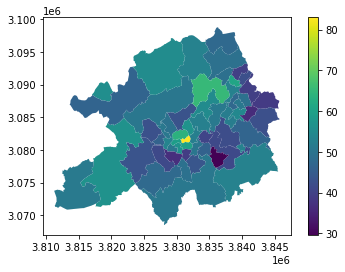

In [72]:
gfa_gu_eub.plot(column='m2cap',legend=True)

Text(0, 0.5, 'Floorspace (m2/cap)')

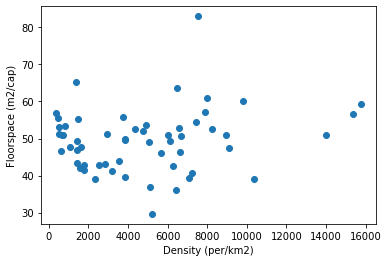

In [73]:
# it is not only the centre where we see an unexpected result (the obvious outlier with >80m2/cap). It is also the lack of a clear downward relationship. 
# Above 6000 per/km2 the m2/cap is often higher than expected. 
# hopefully this resolves as the data become better
plt.scatter(gfa_gu_eub['Density'],gfa_gu_eub['m2cap'])
plt.xlabel("Density (per/km2)")
plt.ylabel("Floorspace (m2/cap)")

In [74]:
bldg_res['Floor_area'].describe()

count    282412.000000
mean        197.272200
std         506.345435
min          10.049665
25%          86.489343
50%         121.723959
75%         175.007112
max       68723.088576
Name: Floor_area, dtype: float64

In [108]:
# geo-unit 101 has a higher median number of stories than most geounits
bldg_res.groupby('geo_unit')['Stories'].median().head(15)

geo_unit
101    4.0
102    4.0
103    3.0
104    3.0
105    4.0
106    3.0
107    2.0
108    2.0
109    3.0
110    2.0
111    3.0
112    2.0
113    2.0
114    1.0
115    2.0
Name: Stories, dtype: float64

In [78]:
# buildings in 101 are considerably larger than average, which is understandable given its proximity to the center and likelood for many large multistorey buildings, but the share of that floor area devoted to residential may be overestimtaed
bldg_res.groupby('geo_unit')['Floor_area'].describe().head(10)

,count,mean,std,min,25%,50%,75%,max
geo_unit,,,,,,,,
101,702.0,906.102742,2313.384799,44.145131,309.975551,521.955140,960.252565,48096.343147
102,1411.0,724.704245,1337.719181,17.142154,269.115400,387.712659,645.317331,24648.716119
103,3606.0,321.974012,591.622634,15.428149,124.557470,219.804734,328.470460,17118.469338
104,2783.0,376.120154,835.859251,18.916375,107.333114,189.010881,308.792795,11431.968946
105,1590.0,579.643378,913.703205,27.377332,223.716855,337.476832,530.033943,10569.526003
106,2213.0,549.192623,1101.891757,16.005431,161.247843,282.517184,507.099749,20907.379382
107,3254.0,329.750513,970.604068,10.568716,106.825334,162.687874,242.344227,25464.078242
108,4518.0,195.232413,376.153260,17.266482,93.686189,135.930570,185.711240,8793.473954
109,2475.0,320.293015,854.247598,14.352108,91.893142,158.468609,253.104508,23934.634320


In [79]:
# see here for building types
# maybe using this file i can figure out how many mix-use and partly residential buildings exist in each postcode, to see if I can control for that somehow, and equlise the estimate of residential floorspace in each geo_unit
bdt=pd.read_csv('../../MSCA_data/DPE/open_data_millesime_2022-10-c_dep59_csv/csv/batiment_groupe_bdtopo_bat.csv')
bdt

,batiment_groupe_id,code_departement_insee,l_nature,l_usage_1,l_usage_2,l_etat,hauteur_mean,altitude_sol_mean
0,59626000ZD0062_81482eddb4148c0,59,"[ ""Fort, blockhaus, casemate"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",5,107.0
1,590430000A0992_c9e95b8a3e782f2,59,"[ ""Chapelle"" ]","[ ""Religieux"" ]",NaN,"[ ""En service"" ]",1,29.0
2,uf592520097169_45a6275f4246c8b,59,"[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",6,18.0
3,uf593080411204_978efb49cb521b7,59,"[ ""Indifférenciée"" ]","[ ""Indifférencié"" ]",NaN,"[ ""En service"" ]",4,43.0
4,uf593050411146_854550cccdbe726,59,"[ ""Indifférenciée"" ]","[ ""Résidentiel"" ]",NaN,"[ ""En service"" ]",3,15.0
...,...,...,...,...,...,...,...,...
890598,596060000E0024_d58d2e711ef3341,59,"[ ""Indifférenciée"" ]","[ ""Résidentiel"" ]","[ ""Annexe"" ]","[ ""En service"" ]",4,30.0
890599,uf596020244723_b50d302d040e6aa,59,"[ ""Indifférenciée"" ]","[ ""Résidentiel"" ]",NaN,"[ ""En service"" ]",3,29.0
890600,594000000A0248_855c239f58a786f,59,"[ ""Indifférenciée"" ]","[ ""Résidentiel"" ]",NaN,"[ ""En service"" ]",7,18.0
890601,59112000AD0393_9d1c371e536d1ca,59,"[ ""Indifférenciée"" ]","[ ""Résidentiel"" ]",NaN,"[ ""En service"" ]",6,21.0


In [80]:
bldg_gu['type_sourc'].value_counts()

Résidentiel               283133
Indifférencié             155322
Annexe                     53427
Commercial et services     18448
Industriel                  4073
Agricole                     938
Sportif                      799
Religieux                    496
Name: type_sourc, dtype: int64

In [81]:
# currently no buildings with non-residential source type labels are labelled as residential
bldg_gu['type'].value_counts()

residential        283133
non-residential     78181
Name: type, dtype: int64

In [83]:
# for now we scale up living area and energy and emissions by the ratio of GFA in the dpe sample to GFA in EUBUCCO
# what do we do about the unknown vintages from eubucco? 
# distribute them across all vintages based on the shares vintage shares calculated with known vintages
gfa_vint_gu_eub.head()


,geo_unit,vintage,Floor_area
0,101,1948-1974,54777.022679
1,101,1975-1977,6349.450409
2,101,1978-1982,42816.338424
3,101,1983-1988,6158.326615
4,101,1989-2000,36010.279007


In [84]:
dpe_gu['periode_construction_dpe'].unique()

array(['2006-2012', 'avant 1948', '1948-1974', '1989-2000', '1978-1982',
       '1975-1977', '1983-1988', '2001-2005', '2013-2021', 'après 2021'],
      dtype=object)

In [85]:
# match labelling with that from EUBUCCO
dpe_gu.loc[dpe_gu['periode_construction_dpe']=='avant 1948','periode_construction_dpe']='<1948'
dpe_gu.loc[dpe_gu['periode_construction_dpe']=='après 2021','periode_construction_dpe']='2022+'
dpe_gu['periode_construction_dpe'].unique()

array(['2006-2012', '<1948', '1948-1974', '1989-2000', '1978-1982',
       '1975-1977', '1983-1988', '2001-2005', '2013-2021', '2022+'],
      dtype=object)

In [86]:
dpe_sum_gu=pd.DataFrame(dpe_gu.groupby(['geo_unit','periode_construction_dpe'])['living_area','gross_floor_area','final_energy_kWh','emissions_kgCO2'].sum()).reset_index()
dpe_sum_gu.head()

C:\Users\peter\AppData\Local\Temp\ipykernel_11736\3915936377.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  dpe_sum_gu=pd.DataFrame(dpe_gu.groupby(['geo_unit','periode_construction_dpe'])['living_area','gross_floor_area','final_energy_kWh','emissions_kgCO2'].sum()).reset_index()


,geo_unit,periode_construction_dpe,living_area,gross_floor_area,final_energy_kWh,emissions_kgCO2
0,101,1948-1974,2497.840001,2997.408002,575348.701350,118299.855400
1,101,1975-1977,107.490000,128.988000,17255.210000,3939.290000
2,101,1978-1982,206.109000,247.330801,24685.461646,1704.149135
3,101,1983-1988,220.020000,264.024000,15872.655464,1032.410200
4,101,1989-2000,1630.738997,1956.886797,194576.090261,27136.166219


Now we check how much of the GFA of each vintage is represented in each spatial unit

In [91]:
gfa_vint_gu_eub=pd.DataFrame(bldg_res.groupby(['geo_unit','vintage'])['Floor_area'].sum()).reset_index()
gfa_vint_gu_eub

,geo_unit,vintage,Floor_area
0,101,1948-1974,54777.022679
1,101,1975-1977,6349.450409
2,101,1978-1982,42816.338424
3,101,1983-1988,6158.326615
4,101,1989-2000,36010.279007
...,...,...,...
565,157,2001-2005,37654.073500
566,157,2006-2012,111407.769720
567,157,2013-2021,14409.438583
568,157,<1948,357149.909076


In [92]:
gfa_vint_gu_eub=gfa_vint_gu_eub.merge(gfa_gu_eub.loc[:,['geo_unit','Floor_area']].rename(columns={'Floor_area':'Floor_area_total'}))
gfa_vint_gu_eub.head()

,geo_unit,vintage,Floor_area,Floor_area_total
0,101,1948-1974,54777.022679,636084.124747
1,101,1975-1977,6349.450409,636084.124747
2,101,1978-1982,42816.338424,636084.124747
3,101,1983-1988,6158.326615,636084.124747
4,101,1989-2000,36010.279007,636084.124747


In [93]:
gfa_vint_gu_eub_noNA=pd.DataFrame(bldg_res.loc[bldg_res['vintage']!='unknown',:].groupby(['geo_unit','vintage'])['Floor_area'].sum()).reset_index()
gfa_vint_gu_eub_noNA=gfa_vint_gu_eub_noNA.merge(pd.DataFrame(bldg_res.loc[bldg_res['vintage']!='unknown',:].groupby(['geo_unit'])['Floor_area'].sum()).reset_index().rename(columns={'Floor_area':'Partial_total'}))
gfa_vint_gu_eub_noNA['shares_noNA']=gfa_vint_gu_eub_noNA['Floor_area']/gfa_vint_gu_eub_noNA['Partial_total']
gfa_vint_gu_eub_noNA.head()

,geo_unit,vintage,Floor_area,Partial_total,shares_noNA
0,101,1948-1974,54777.022679,537458.769446,0.101919
1,101,1975-1977,6349.450409,537458.769446,0.011814
2,101,1978-1982,42816.338424,537458.769446,0.079664
3,101,1983-1988,6158.326615,537458.769446,0.011458
4,101,1989-2000,36010.279007,537458.769446,0.067001


In [94]:
# calculate estimated floor area by scaling the known vintage shares by the actual GFA totals
gfa_vint_gu_eub=gfa_vint_gu_eub.merge(gfa_vint_gu_eub_noNA,how='left')
gfa_vint_gu_eub['Floor_area_est']=gfa_vint_gu_eub['shares_noNA']*gfa_vint_gu_eub['Floor_area_total']
gfa_vint_gu_eub

,geo_unit,vintage,Floor_area,Floor_area_total,Partial_total,shares_noNA,Floor_area_est
0,101,1948-1974,54777.022679,6.360841e+05,537458.769446,0.101919,64828.776657
1,101,1975-1977,6349.450409,6.360841e+05,537458.769446,0.011814,7514.594301
2,101,1978-1982,42816.338424,6.360841e+05,537458.769446,0.079664,50673.269653
3,101,1983-1988,6158.326615,6.360841e+05,537458.769446,0.011458,7288.398697
4,101,1989-2000,36010.279007,6.360841e+05,537458.769446,0.067001,42618.277170
...,...,...,...,...,...,...,...
565,157,2001-2005,37654.073500,1.047350e+06,944407.784279,0.039871,41758.446543
566,157,2006-2012,111407.769720,1.047350e+06,944407.784279,0.117966,123551.450450
567,157,2013-2021,14409.438583,1.047350e+06,944407.784279,0.015258,15980.097632
568,157,<1948,357149.909076,1.047350e+06,944407.784279,0.378173,396079.998776


In [95]:
gfa_vint_gu_eub.drop(columns={'Floor_area_total','Partial_total','shares_noNA'},inplace=True)
dpe_sum_gu.rename(columns={'periode_construction_dpe':'vintage'},inplace=True)
gfa_vint_gu_eub

,geo_unit,vintage,Floor_area,Floor_area_est
0,101,1948-1974,54777.022679,64828.776657
1,101,1975-1977,6349.450409,7514.594301
2,101,1978-1982,42816.338424,50673.269653
3,101,1983-1988,6158.326615,7288.398697
4,101,1989-2000,36010.279007,42618.277170
...,...,...,...,...
565,157,2001-2005,37654.073500,41758.446543
566,157,2006-2012,111407.769720,123551.450450
567,157,2013-2021,14409.438583,15980.097632
568,157,<1948,357149.909076,396079.998776


### 6. Combine data to esimate residential energy/cap and emissions/cap in each spatial unit

In [96]:
# merge with the summary DPE stats
summary_dpe_eub=gfa_vint_gu_eub.merge(dpe_sum_gu,how='left')
summary_dpe_eub['GFA_ratio']=summary_dpe_eub['Floor_area_est']/summary_dpe_eub['gross_floor_area']
summary_dpe_eub

,geo_unit,vintage,Floor_area,Floor_area_est,living_area,gross_floor_area,final_energy_kWh,emissions_kgCO2,GFA_ratio
0,101,1948-1974,54777.022679,64828.776657,2497.840001,2997.408002,5.753487e+05,118299.855400,21.628279
1,101,1975-1977,6349.450409,7514.594301,107.490000,128.988000,1.725521e+04,3939.290000,58.258088
2,101,1978-1982,42816.338424,50673.269653,206.109000,247.330801,2.468546e+04,1704.149135,204.880547
3,101,1983-1988,6158.326615,7288.398697,220.020000,264.024000,1.587266e+04,1032.410200,27.605061
4,101,1989-2000,36010.279007,42618.277170,1630.738997,1956.886797,1.945761e+05,27136.166219,21.778611
...,...,...,...,...,...,...,...,...,...
565,157,2001-2005,37654.073500,41758.446543,1557.550000,1869.060000,1.581526e+05,24274.644600,22.341951
566,157,2006-2012,111407.769720,123551.450450,6654.457999,7985.349599,5.863258e+05,61910.749568,15.472266
567,157,2013-2021,14409.438583,15980.097632,727.050000,872.460000,6.322244e+04,9231.170000,18.316138
568,157,<1948,357149.909076,396079.998776,13688.457002,16426.148402,2.556281e+06,491622.292942,24.112774


In [97]:
# in 3 cases the dpe data actually exceed the eubucco data, pointing to potential underestimtations in some segments of EUBUCCO
summary_dpe_eub['GFA_ratio'].describe()

count    497.000000
mean      41.147117
std       43.689520
min        0.437554
25%       20.687227
50%       28.747937
75%       42.415953
max      370.650473
Name: GFA_ratio, dtype: float64

In [98]:
# scale up the estimates of emissions and energy per spatial unit, using the GFA ratio
summary_dpe_eub['final_energy_tot_GWh']=summary_dpe_eub['final_energy_kWh']*summary_dpe_eub['GFA_ratio']*1e-6
summary_dpe_eub['emissions_ktCO2']=summary_dpe_eub['emissions_kgCO2']*summary_dpe_eub['GFA_ratio']*1e-6
summary_dpe_eub

,geo_unit,vintage,Floor_area,Floor_area_est,living_area,gross_floor_area,final_energy_kWh,emissions_kgCO2,GFA_ratio,final_energy_tot_GWh,emissions_ktCO2
0,101,1948-1974,54777.022679,64828.776657,2497.840001,2997.408002,5.753487e+05,118299.855400,21.628279,12.443802,2.558622
1,101,1975-1977,6349.450409,7514.594301,107.490000,128.988000,1.725521e+04,3939.290000,58.258088,1.005256,0.229496
2,101,1978-1982,42816.338424,50673.269653,206.109000,247.330801,2.468546e+04,1704.149135,204.880547,5.057571,0.349147
3,101,1983-1988,6158.326615,7288.398697,220.020000,264.024000,1.587266e+04,1032.410200,27.605061,0.438166,0.028500
4,101,1989-2000,36010.279007,42618.277170,1630.738997,1956.886797,1.945761e+05,27136.166219,21.778611,4.237597,0.590988
...,...,...,...,...,...,...,...,...,...,...,...
565,157,2001-2005,37654.073500,41758.446543,1557.550000,1869.060000,1.581526e+05,24274.644600,22.341951,3.533437,0.542343
566,157,2006-2012,111407.769720,123551.450450,6654.457999,7985.349599,5.863258e+05,61910.749568,15.472266,9.071789,0.957900
567,157,2013-2021,14409.438583,15980.097632,727.050000,872.460000,6.322244e+04,9231.170000,18.316138,1.157991,0.169079
568,157,<1948,357149.909076,396079.998776,13688.457002,16426.148402,2.556281e+06,491622.292942,24.112774,61.639032,11.854377


In [99]:
# summar over vintages to get total energy and emissions per spatial unit
eetot_gu=summary_dpe_eub.groupby('geo_unit')['final_energy_tot_GWh','emissions_ktCO2'].sum().reset_index()

C:\Users\peter\AppData\Local\Temp\ipykernel_11736\4097074377.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  eetot_gu=summary_dpe_eub.groupby('geo_unit')['final_energy_tot_GWh','emissions_ktCO2'].sum().reset_index()


In [104]:
# summary of population, floor area, m2/cap, energy and emissions absolute and per cap per each spatial unit
summary=gfa_gu_eub.merge(eetot_gu)
summary['FE_MWhcap']=1e3*summary['final_energy_tot_GWh']/summary['Population']
summary['GHG_tcap']=1e3*summary['emissions_ktCO2']/summary['Population']
summary.head(10)

,geo_unit,geometry,area,Population,Density,Floor_area,m2cap,final_energy_tot_GWh,emissions_ktCO2,FE_MWhcap,GHG_tcap
0,101,"POLYGON ((3832165.491 3081763.495, 3832118.517...",1.019414,7663.0,7517.0,6.360841e+05,83.007194,96.764972,16.680072,12.627557,2.176703
1,102,"POLYGON ((3830948.302 3080000.986, 3830842.526...",1.736899,17020.0,9799.0,1.022558e+06,60.079770,139.544236,23.345614,8.198839,1.371658
2,103,"POLYGON ((3830813.962 3079445.052, 3830830.781...",1.332421,20474.0,15366.0,1.161038e+06,56.707936,149.218172,21.671101,7.288179,1.058469
3,104,"POLYGON ((3830131.702 3080002.606, 3830140.054...",1.467545,20511.0,13976.0,1.046742e+06,51.033221,158.456133,28.329880,7.725422,1.381204
4,105,"POLYGON ((3829671.427 3080837.090, 3829662.212...",0.989090,15571.0,15743.0,9.216330e+05,59.189068,128.247436,20.108074,8.236301,1.291380
5,106,"POLYGON ((3831810.688 3082274.034, 3831803.157...",2.957367,19086.0,6454.0,1.215363e+06,63.678260,136.651098,18.150830,7.159756,0.951002
6,107,"POLYGON ((3833501.848 3082846.705, 3833549.183...",2.479507,20460.0,8252.0,1.073008e+06,52.444192,147.463124,26.858827,7.207386,1.312748
7,108,"POLYGON ((3831926.590 3079251.636, 3831955.356...",2.620403,17440.0,6655.0,8.820600e+05,50.576837,123.231946,22.206507,7.066052,1.273309
8,109,"POLYGON ((3832053.301 3079193.884, 3832120.196...",1.948714,20223.0,10378.0,7.927252e+05,39.199190,107.710311,18.519911,5.326129,0.915785
9,110,"POLYGON ((3830262.285 3079466.981, 3830315.640...",3.840035,19726.0,5137.0,7.272166e+05,36.865894,121.266725,23.262946,6.147558,1.179304


In [101]:
# French total emissions are 5-6 t/cap, and residential is about 20% of total, so residential GHG should be about 1 t/cap, or slightly higher, which is consistent with what we see here. https://www.planete-energies.com/en/media/article/greenhouse-gas-emissions-france
# Nord is in the north of france, with higher heating requirements, so it would be natural to see estimates here which are above national average. 
# However, in an urban region such as we have here, with probably lower m2/cap than national average (once we have our data right), emissions would be lower than in rural areas
summary['GHG_tcap'].describe()

count    57.000000
mean      1.306885
std       0.232659
min       0.753944
25%       1.177875
50%       1.276658
75%       1.431900
max       2.176703
Name: GHG_tcap, dtype: float64

<AxesSubplot:>

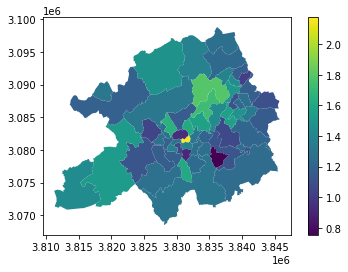

In [102]:
summary.plot(column='GHG_tcap',legend=True)

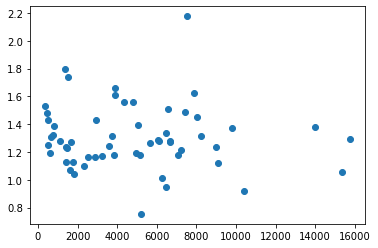

In [103]:
# also very little variation with density, that is not what we expect to see. 
plt.scatter(summary['Density'],summary['GHG_tcap'])

I expect the floor area estimations are the primary source of error here, whereby residential FA is overestimated in EUBUCCO compared to the DPE sample. 